In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore", message="An unsupported index was provided.*")
warnings.filterwarnings("ignore", message="No supported index is available.*")
pd.set_option('display.float_format', '{:.2f}'.format)

ModuleNotFoundError: No module named 'statsmodels'

In [38]:
df_climate = pd.read_csv('data/climate.csv')
df_climate['year'] = df_climate['year'].astype(int)
df_climate = df_climate.sort_values(['country_code', 'year'])
print(f'Loaded {len(df_climate)} rows for {df_climate['country_code'].nunique()} countries.')

Loaded 29363 rows for 180 countries.


In [39]:
def evaluate_country(country_code):
    country_data = df_climate[df_climate['country_code'] == country_code].copy()
    if country_data.empty:
        raise ValueError(f'No data for {country_code}')
    aggregated = country_data.groupby('year', as_index=False)['temp_mean'].mean()
    train = aggregated[(aggregated['year'] >= 2003) & (aggregated['year'] <= 2017)]
    test = aggregated[(aggregated['year'] >= 2017) & (aggregated['year'] <= 2020)]
    if len(train) < 10 or len(test) < 1:
        raise ValueError(f'Insufficient data for {country_code}')
    ts = train.set_index('year')['temp_mean']
    model_hw = ExponentialSmoothing(ts, trend='add', seasonal=None)
    fitted_hw = model_hw.fit(optimized=True)
    forecast_years = np.arange(2017, 2021)
    hw_pred = fitted_hw.forecast(steps=len(forecast_years))
    model_damped = ExponentialSmoothing(ts, trend='add', seasonal=None, damped_trend=True)
    fitted_damped = model_damped.fit(optimized=True)
    hw_damped_pred = fitted_damped.forecast(steps=len(forecast_years))
    mape_hw = mean_absolute_percentage_error(test['temp_mean'].values, hw_pred[:len(test)])
    mape_damped = mean_absolute_percentage_error(test['temp_mean'].values, hw_damped_pred[:len(test)])
    return {
        'country': country_code,
        'train_years': train['year'],
        'train_values': train['temp_mean'],
        'test_years': test['year'],
        'test_values': test['temp_mean'],
        'forecast_years': forecast_years,
        'hw_pred': hw_pred,
        'hw_damped_pred': hw_damped_pred,
        'mape_hw': mape_hw,
        'mape_damped': mape_damped
    }

Country: USA
Holt-Winters MAPE: 6.26%
Holt-Winters Damped MAPE: 5.86%


ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

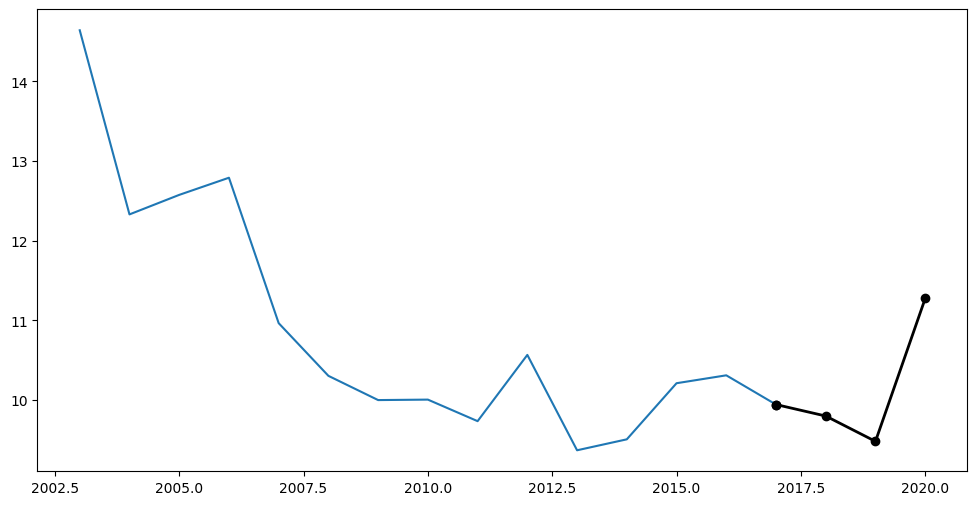

In [ ]:
result = evaluate_country('USA')
print('Country:', result['country'])
print(f'Holt-Winters MAPE: {result['mape_hw']:.2%}')
print(f'Holt-Winters Damped MAPE: {result['mape_damped']:.2%}')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result['train_years'], result['train_values'], label='Train (2003-2017)', color='tab:blue')
last_train_year = result['train_years'].iloc[-1]
last_train_value = result['train_values'].iloc[-1]
test_years = result['test_years'].values
test_values = result['test_values'].values
test_line_years = np.concatenate([[last_train_year], test_years])
test_line_values = np.concatenate([[last_train_value], test_values])
ax.plot(test_line_years, test_line_values, 'o-', label='Actual Test (2017-2020)', color='black', linewidth=2)
hw_forecast_years = np.array(result['forecast_years'])
hw_pred_vals = np.asarray(result['hw_pred'])[:len(hw_forecast_years)].copy()
hw_damped_pred_vals = np.asarray(result['hw_damped_pred'])[:len(hw_forecast_years)].copy()
if len(result['test_years']) and hw_forecast_years[0] == result['test_years'].iloc[0]:
    actual_start = result['test_values'].iloc[0]
    hw_pred_vals[0] = actual_start
    hw_damped_pred_vals[0] = actual_start
ax.plot(hw_forecast_years, hw_pred_vals, 's--', label='Holt-Winters', color='tab:red')
ax.plot(hw_forecast_years, hw_damped_pred_vals, '^-', label='Holt-Winters Damped', color='tab:green')
ax.set_title('Holt-Winters Models on temp_mean for USA')
ax.set_xlabel('Year')
ax.set_ylabel('temp_mean')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [36]:
all_countries = sorted(df_climate['country_code'].unique())
sample_countries = random.sample(all_countries, min(10, len(all_countries)))
metrics = []
print(f"Evaluating {len(sample_countries)} countries: {', '.join(sample_countries)}")
for country in sample_countries:
    try:
        stats = evaluate_country(country)
        metrics.append(stats)
        print(f"{country}: HW MAPE={stats['mape_hw']:.2%}, Damped MAPE={stats['mape_damped']:.2%}")
    except Exception as err:
        print(f"{country}: {err}")
if metrics:
    mean_hw = np.mean([s['mape_hw'] for s in metrics])
    mean_damped = np.mean([s['mape_damped'] for s in metrics])
    print('Mean HW MAPE:', f'{mean_hw:.2%}')
    print('Mean HW Damped MAPE:', f'{mean_damped:.2%}')

Evaluating 10 countries: BWA, FJI, PRT, GBR, MMR, BRA, SWE, GRL, JPN, VUT
BWA: Insufficient data for BWA
FJI: HW MAPE=5.35%, Damped MAPE=5.40%
PRT: HW MAPE=1.50%, Damped MAPE=1.65%
GBR: HW MAPE=9.42%, Damped MAPE=7.97%
MMR: Insufficient data for MMR
BRA: HW MAPE=0.54%, Damped MAPE=0.54%
SWE: HW MAPE=11.43%, Damped MAPE=11.09%
GRL: HW MAPE=14.91%, Damped MAPE=11.36%
JPN: HW MAPE=9.14%, Damped MAPE=4.62%
VUT: Insufficient data for VUT
Mean HW MAPE: 7.47%
Mean HW Damped MAPE: 6.09%
